In [3]:
import os
os.chdir(r'C:\Users\nadda\Desktop\KU\01204314-65-Statistics-for-Computer-Engineering-Applications\week9')
os.getcwd()

'C:\\Users\\nadda\\Desktop\\KU\\01204314-65-Statistics-for-Computer-Engineering-Applications\\week9'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('monthly-milk-production.csv')
df.head()

,Month,MilkProduction
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


##### String Time Format Code List: https://strftime.org/

In [6]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

In [7]:
df.set_index('Month',inplace=True)

In [8]:
df.head()

,MilkProduction
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [9]:
# Detecting and removing outliers using Z-score
from scipy.stats import zscore
z_scores = zscore(df)
abs_z_scores = np.abs(z_scores)
zscore_threshold = 3 #any data above mean +/- (this_threshold)*sd is considered outliers
outliers = (abs_z_scores > zscore_threshold)  # Z-score threshold
df = df[~outliers]
df.head(10)

,MilkProduction
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
1962-06-01,697
1962-07-01,640
1962-08-01,599
1962-09-01,568


<Figure size 640x480 with 0 Axes>

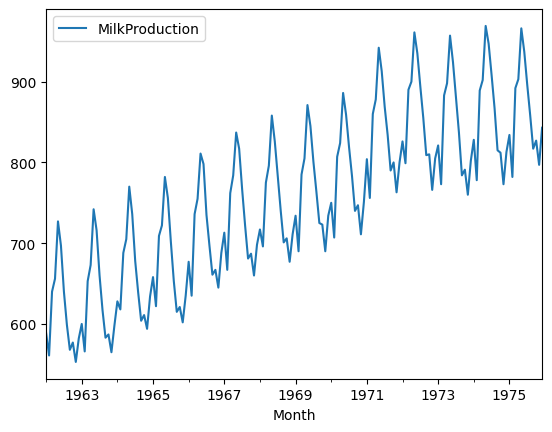

In [10]:
plt.clf()
df.plot()
plt.show()

### Decomposition

<Figure size 2000x800 with 0 Axes>

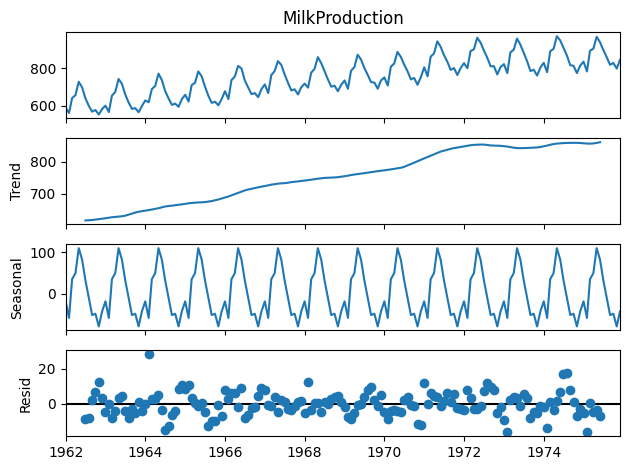

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['MilkProduction'])  
fig = plt.figure(figsize=(20,8))  
decomposition.plot()  
plt.show()

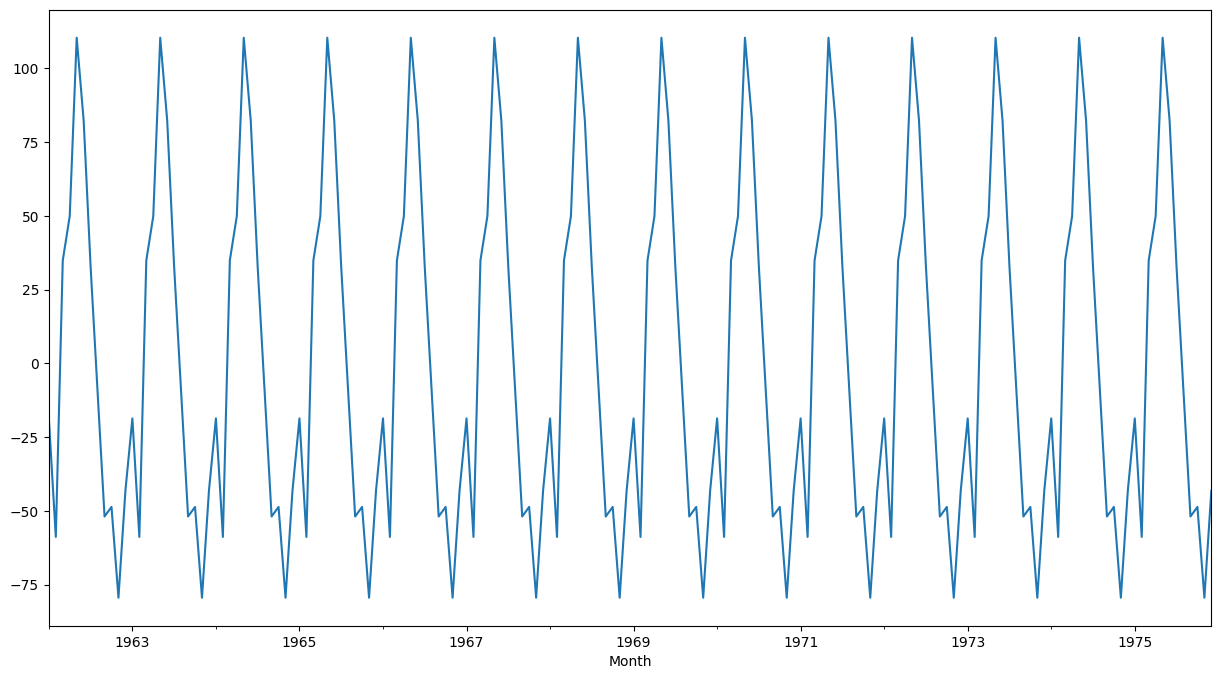

In [12]:
fig = plt.figure(figsize=(15,8))  
decomposition.seasonal.plot()
plt.show()

In [13]:
# From the plot above, we can see that seasonal pattern lasts for 12 months (1 year)
seasonal_period = 12

### Check Stationary

In [14]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['MilkProduction'])
result

(-1.3038115874221345,
 0.6274267086030293,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

In [15]:
def check_adfuller(time_series, alpha=0.05):
    """
    Function to check whether timeseries is stationary or not
    Pass in a time series, returns adfuller test result
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= alpha:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("Do not reject the null hypothesis. Data is not stationary ")

In [16]:
check_adfuller(df['MilkProduction'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.3038115874221345
p-value : 0.6274267086030293
#Lags Used : 13
Number of Observations Used : 154
Do not reject the null hypothesis. Data is not stationary 


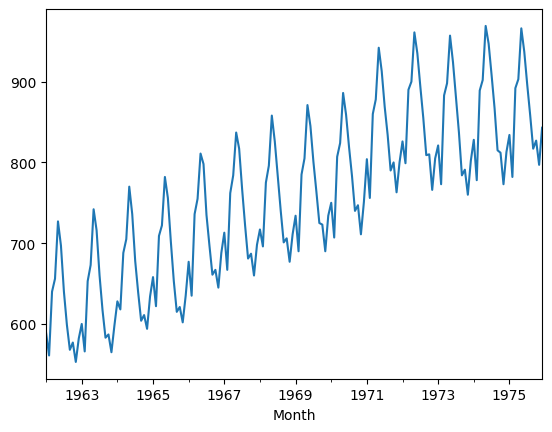

In [17]:
df['MilkProduction'].plot()
plt.show()

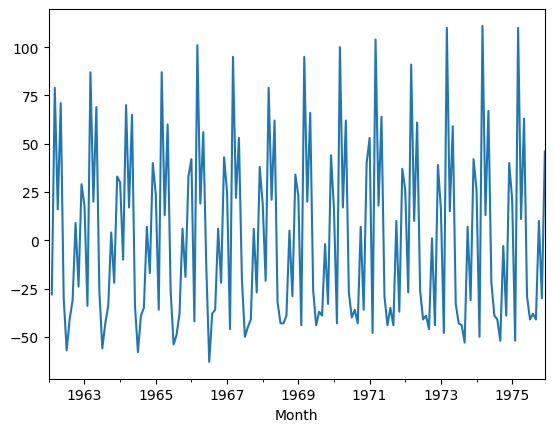

In [18]:
# Since the original timeseries is not stationary, we derive the first-order differenced series
first_difference = df['MilkProduction'] - df['MilkProduction'].shift(1)
first_difference.plot()
plt.show()

In [19]:
# Check whether the first-order differenced series is stationary
check_adfuller(first_difference.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.0549955586530833
p-value : 0.030068004001784585
#Lags Used : 14
Number of Observations Used : 152
Reject the null hypothesis. Data is stationary


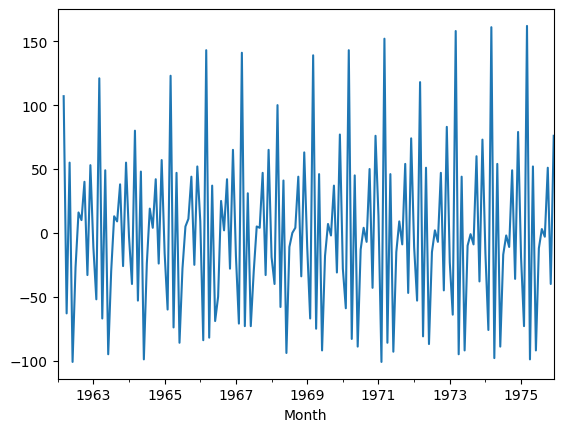

In [20]:
# Although the first-order differenced series is already stationary, 
#          let's check the stationary property of the second-order differenced series
# Derive the second-order differenced series
second_difference = first_difference - first_difference.shift(1)
second_difference.plot()
plt.show()

In [21]:
# Check whether the second-order differenced series is stationary
check_adfuller(second_difference.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -14.327873645603294
p-value : 1.1126989332085062e-26
#Lags Used : 11
Number of Observations Used : 154
Reject the null hypothesis. Data is stationary


In [22]:
# Since the first-order differenced series is stationary, we set difference parameter (d) = 1
d = 1

In [23]:
def find_difference_parameter(timeseries, alpha=0.05):
    """
    Function to find difference parameter by 
    Pass in a time series, returns adfuller test result
    """
    p_values = []

    for lag in range(1, 10):
        test = adfuller(timeseries.diff(lag).dropna())
        p_values.append((lag, test[1]))    # test[1] = p-value from adfuller

    significant_lag = [p for p in p_values if p[1] < alpha]   # collect lag, p-values are below alpha
    sorted_significant_lag = sorted(significant_lag)  # sort lags that p-values are below alpha ascendingly (min to max)
    difference_parameter = sorted_significant_lag[0][0]  # get minimum lag that its p-value is below alpha

    return difference_parameter, sorted_significant_lag

In [24]:
d, sorted_significant_lag = find_difference_parameter(df['MilkProduction'], 0.05)
d

1

In [25]:
sorted_significant_lag

[(1, 0.030068004001784585),
 (2, 0.0289649533754665),
 (3, 0.029330317990775834),
 (4, 0.026782916171287405),
 (5, 0.019101299356666292),
 (6, 0.01373024379447667),
 (7, 0.0010430084060719822),
 (8, 0.0021551201097330342),
 (9, 1.6246571860240873e-05)]

In [26]:
d2, sorted_significant_lag2 = find_difference_parameter(df['MilkProduction'], 0.01)
print(d2)
print(sorted_significant_lag2)

7
[(7, 0.0010430084060719822), (8, 0.0021551201097330342), (9, 1.6246571860240873e-05)]


### Autocorrelation (ACF) & Partial Autocorrelation (PACF)

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [28]:
first_difference = first_difference.dropna()

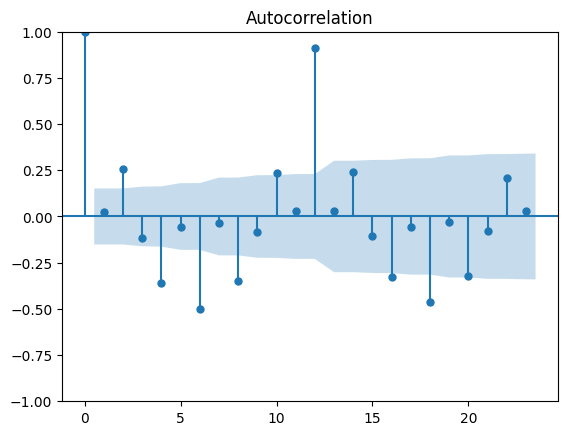

In [29]:
plot_acf(first_difference)  # Notice that series to plot ACF/PACF is stationary
plt.show()

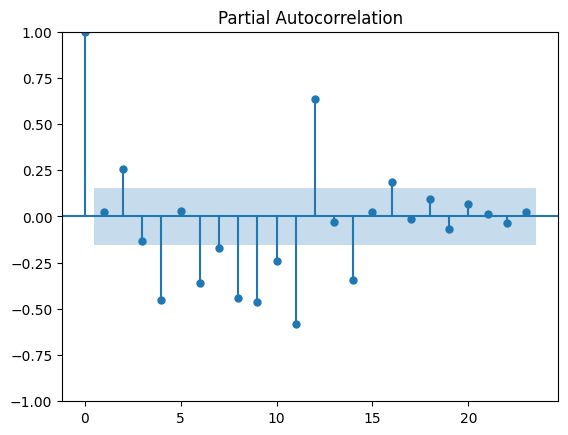

In [30]:
plot_pacf(first_difference) # Notice that series to plot ACF/PACF is stationary
plt.show()

<Figure size 640x480 with 0 Axes>

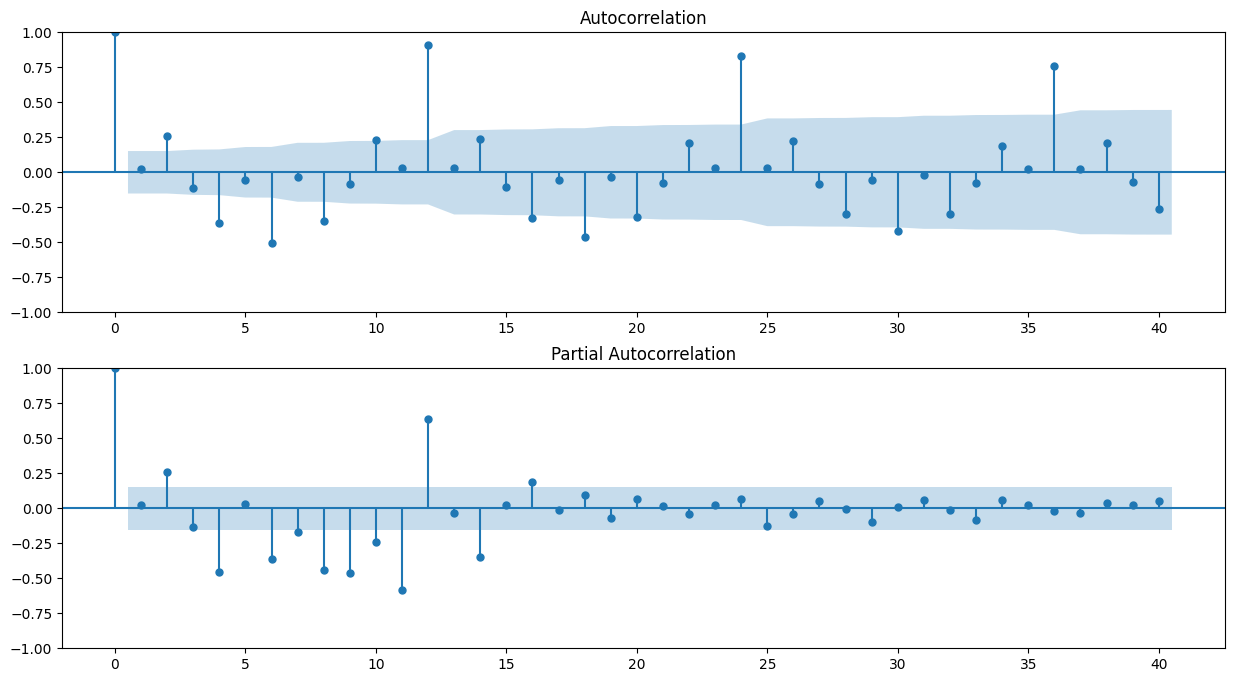

In [31]:
# Plot ACF and PACF together
plt.clf()
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
plot_acf(first_difference, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(first_difference, lags=40, ax=ax2)
plt.show()

In [32]:
### Looking at ACF, possible value of q is 0 or 2.  
### Looking at PACF, possible value of p is 0 or 2. 

### Seasonal: Check Stationary

In [33]:
# From decomposition section above, seasonal_period = 12
seasonal_period

12

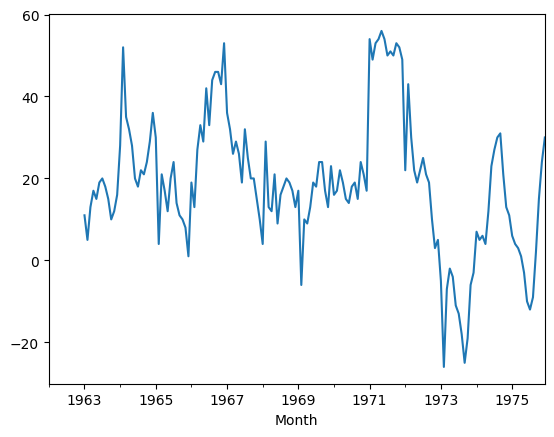

In [34]:
original_seasonal_difference = df['MilkProduction'] - df['MilkProduction'].shift(seasonal_period)
original_seasonal_difference.plot()
plt.show()

In [35]:
check_adfuller(original_seasonal_difference.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.3354193143594
p-value : 0.16079880527711288
#Lags Used : 12
Number of Observations Used : 143
Do not reject the null hypothesis. Data is not stationary 


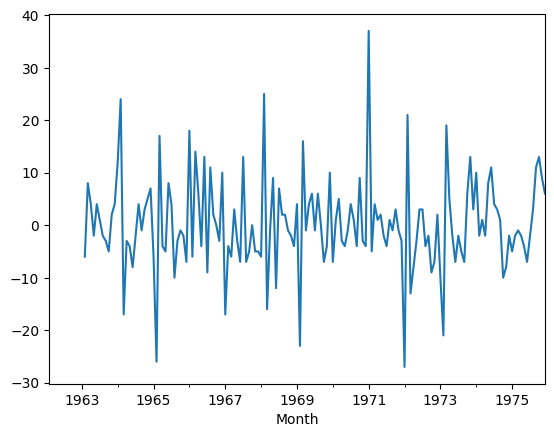

In [36]:
# Since the seasonal part of original timeseries is not stationary, 
#       we derive the first-order difference of seasonal part
first_seasonal_difference = first_difference - first_difference.shift(seasonal_period)
first_seasonal_difference.plot()
plt.show()

In [37]:
# Check whether the first-order difference of seasonal part is stationary or not
check_adfuller(first_seasonal_difference.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.03800227492198
p-value : 1.865423431878859e-05
#Lags Used : 11
Number of Observations Used : 143
Reject the null hypothesis. Data is stationary


In [38]:
# Since the first-order difference of seasonal part is stationary, we set seasonal difference parameter (D) = 1
D = 1

### Seasonal:  Autocorrelation (ACF), Partial Correlation (PACF)

In [39]:
first_seasonal_difference = first_seasonal_difference.dropna()

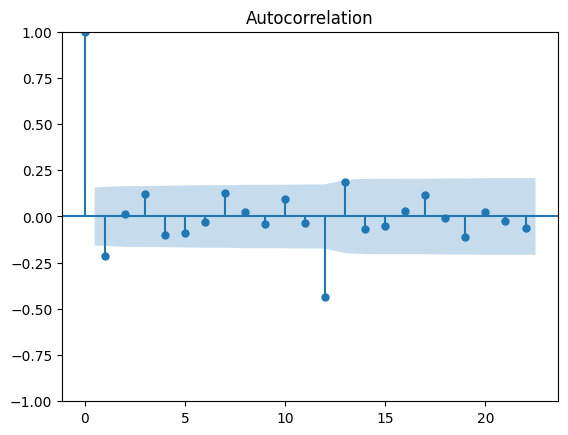

In [40]:
plot_acf(first_seasonal_difference)
plt.show()

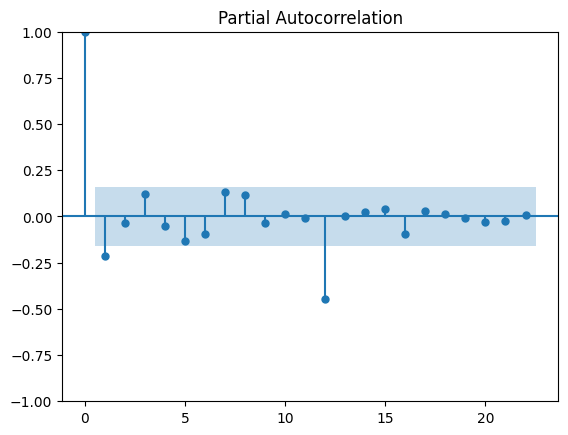

In [41]:
plot_pacf(first_seasonal_difference)
plt.show()

<Figure size 640x480 with 0 Axes>

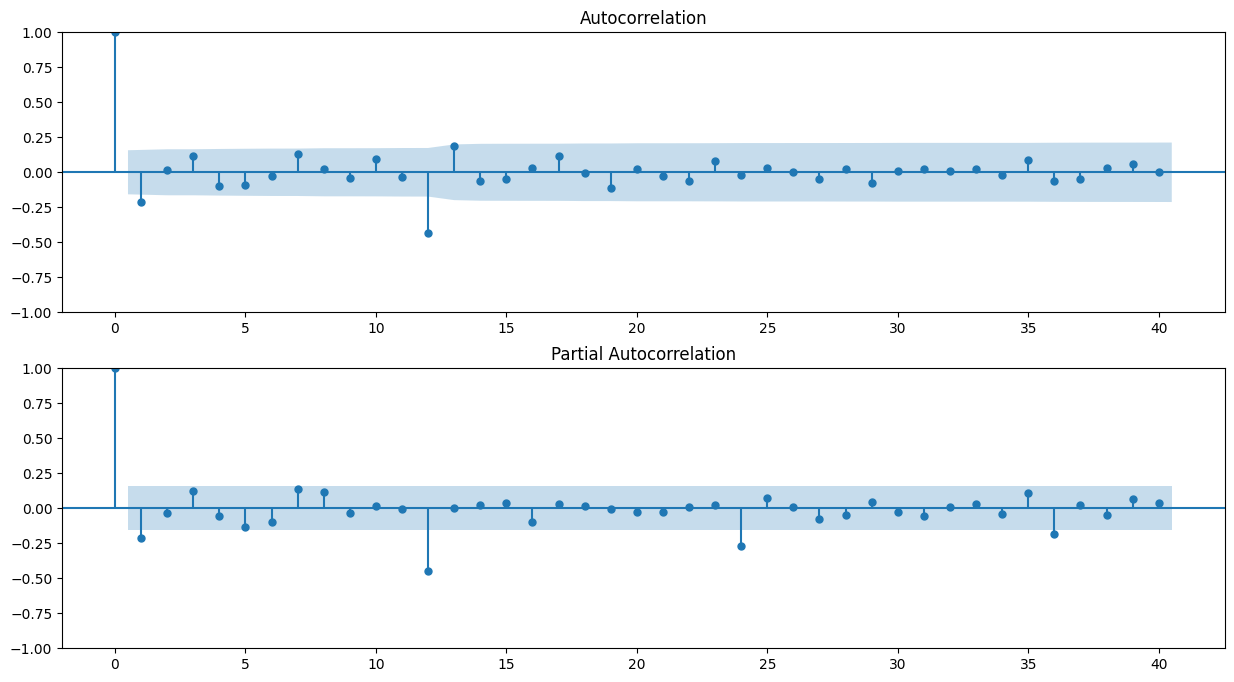

In [42]:
# Plot ACF and PACF together
plt.clf()
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
plot_acf(first_seasonal_difference, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(first_seasonal_difference, lags=40, ax=ax2)
plt.show()

In [43]:
### Looking at ACF, possible value of Q is 0 or 1.  
### Looking at PACF, possible value of P is 0 or 1. 

### ARIMA Model

<Figure size 640x480 with 0 Axes>

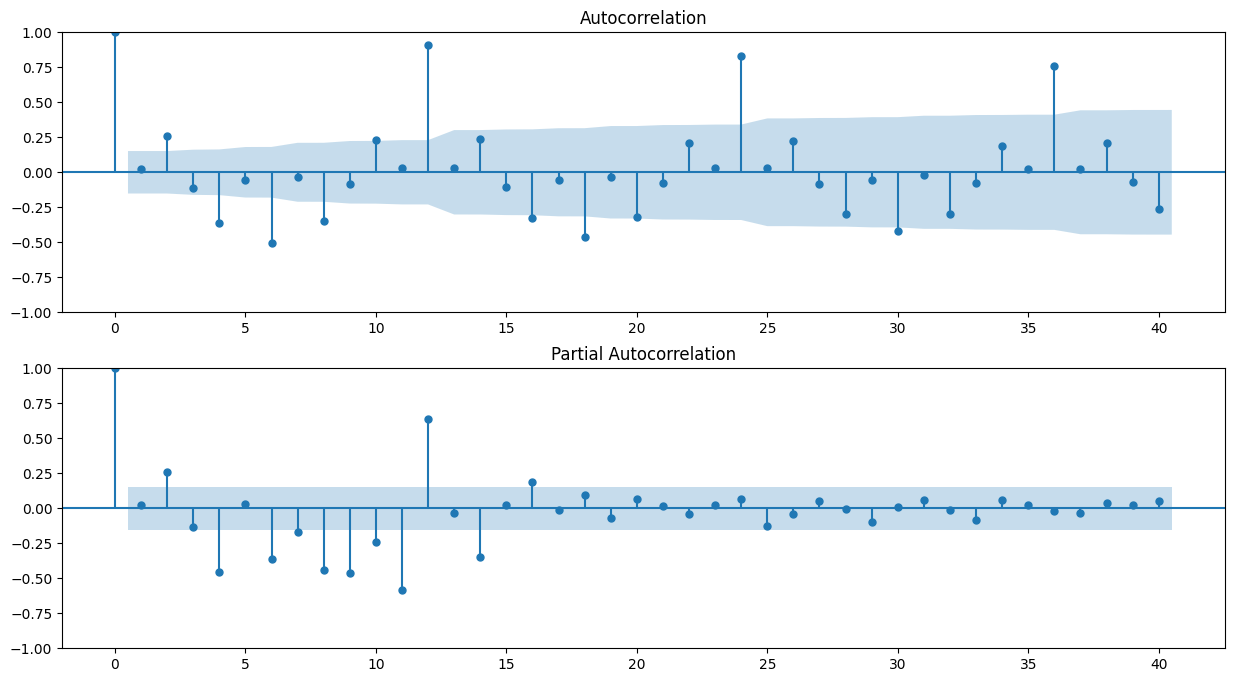

In [44]:
# Plot ACF and PACF together
plt.clf()
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
plot_acf(first_difference, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(first_difference, lags=40, ax=ax2)
plt.show()

### Looking at ACF, possible value of q is 0 or 2.  
### Looking at PACF, possible value of p is 0 or 2. 

In [45]:
### difference parameter d from Check_Stationary section
d

1

In [46]:
from statsmodels.tsa.arima.model import ARIMA

##### See meaning of returned string from inferred_freq at 
##### https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [47]:
# Time index for ARIMA input must have freq parameter set.  
trained_df = df.asfreq(df.index.inferred_freq, method='ffill')

# Run ARIMA with p = 0, q = 0
trained_df = trained_df.dropna() 
model = ARIMA(trained_df, order=(0,d,0))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:         MilkProduction   No. Observations:                  168
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -873.866
Date:                Thu, 30 Jan 2025   AIC                           1749.732
Time:                        05:10:28   BIC                           1752.850
Sample:                    01-01-1962   HQIC                          1750.998
                         - 12-01-1975                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2054.0918    264.229      7.774      0.000    1536.213    2571.970
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                14.81
Prob(Q):                              0.77   Pr

In [48]:
# Run ARIMA with p = 2, q = 2 
model2 = ARIMA(trained_df, order=(2,d,2))
result2 = model2.fit()
print(result2.summary())

                               SARIMAX Results                                
Dep. Variable:         MilkProduction   No. Observations:                  168
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -852.823
Date:                Thu, 30 Jan 2025   AIC                           1715.647
Time:                        05:10:28   BIC                           1731.237
Sample:                    01-01-1962   HQIC                          1721.974
                         - 12-01-1975                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3263      0.114     -2.854      0.004      -0.550      -0.102
ar.L2         -0.4530      0.140     -3.228      0.001      -0.728      -0.178
ma.L1          0.4045      0.035     11.562      0.0

In [49]:
# Run ARIMA models with different values of p and q.  
# The best model is the one with lowest AIC 

model = ARIMA(trained_df,order=(0,d,0))
result = model.fit()
print(result.aic)
model2 = ARIMA(trained_df,order=(2,d,2))
result2 = model2.fit()
print(result2.aic)
model3 = ARIMA(trained_df,order=(0,d,2))
result3 = model3.fit()
print(result3.aic)
model4 = ARIMA(trained_df,order=(2,d,0))
result4 = model4.fit()
print(result4.aic)
model5 = ARIMA(trained_df,order=(1,d,1))
result5 = model5.fit()
print(result5.aic)
model6 = ARIMA(trained_df,order=(0,d,1))
result6 = model6.fit()
print(result6.aic)
model7 = ARIMA(trained_df,order=(1,d,0))
result7 = model7.fit()
print(result7.aic)

1749.73219913295
1715.6467214719773
1728.0471561076383
1742.0641810413672
1753.0163406744966
1751.6713775108847
1751.6398579071597


In [50]:
# From AIC above, p and q values that give the lowest AIC are 2 and 2 respectively.

### SARIMA Model (Seasonal ARIMA Model)

<Figure size 640x480 with 0 Axes>

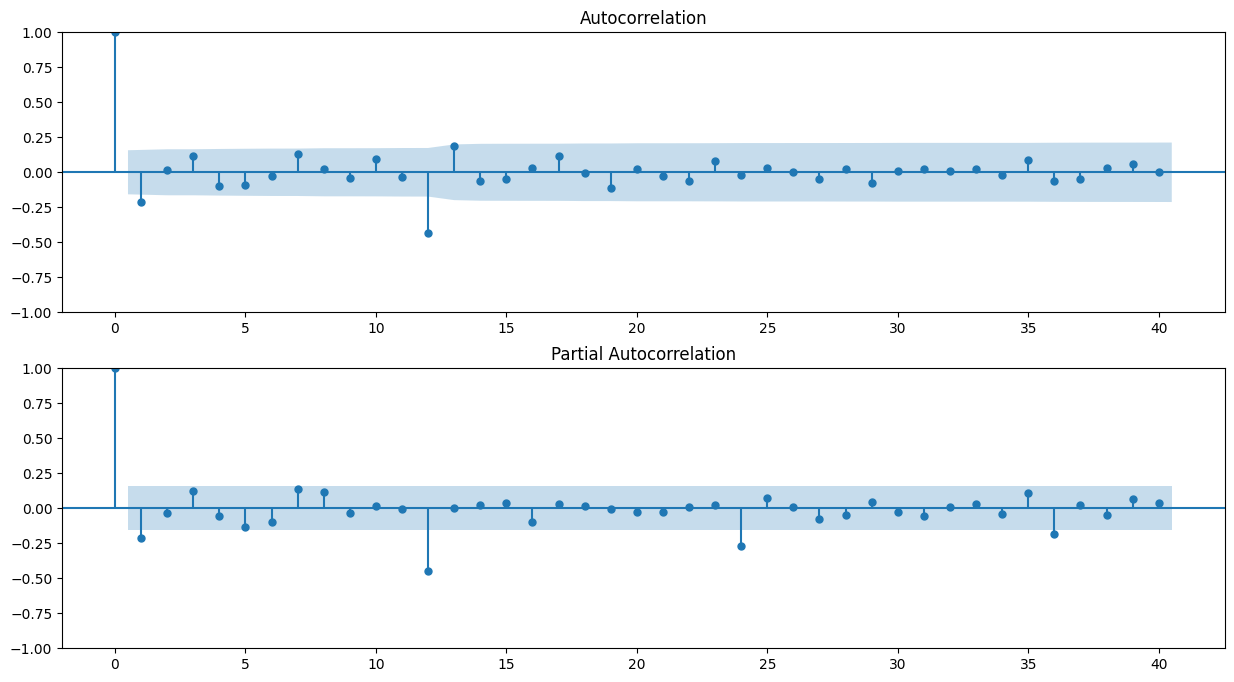

In [51]:
# Plot ACF and PACF together
plt.clf()
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
plot_acf(first_seasonal_difference, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(first_seasonal_difference, lags=40, ax=ax2)
plt.show()
### Looking at ACF, possible value of Q is 0 or 1.  
### Looking at PACF, possible value of P is 0 or 1. 

In [52]:
# Show difference parameters d, seasonal difference parenters D, and seasonal period
print(d)
print(D)
print(seasonal_period)

1
1
12


In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [54]:
# Time index for ARIMA input must have freq parameter set.  
trained_df = df.asfreq(df.index.inferred_freq, method='ffill')

# Run SARIMA 
trained_df = trained_df.dropna()
model = SARIMAX(trained_df, order=(2,d,2), seasonal_order=(1,D,1,seasonal_period))
result = model.fit()
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                       MilkProduction   No. Observations:                  168
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -528.111
Date:                              Thu, 30 Jan 2025   AIC                           1070.222
Time:                                      05:10:31   BIC                           1091.526
Sample:                                  01-01-1962   HQIC                          1078.875
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2836      0.198      1.435      0.151      -0.104       0.671
ar.L2         -0.64

In [55]:
# Run SARIMA 
model = SARIMAX(trained_df, order=(0,d,0), seasonal_order=(1,D,1,seasonal_period))
result = model.fit()
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                       MilkProduction   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -534.065
Date:                              Thu, 30 Jan 2025   AIC                           1074.131
Time:                                      05:10:31   BIC                           1083.261
Sample:                                  01-01-1962   HQIC                          1077.839
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.58

In [56]:
# Run ARIMA models with different values of p, q, P and Q.  
# The best model is the one with lowest AIC 

model = SARIMAX(trained_df, order=(2,d,2), seasonal_order=(0,D,0,seasonal_period))
result = model.fit()
print(result.aic)
model2 = SARIMAX(trained_df, order=(0,d,0), seasonal_order=(0,D,0,seasonal_period))
result2 = model2.fit()
print(result2.aic)
model3 = SARIMAX(trained_df, order=(2,d,2), seasonal_order=(1,D,1,seasonal_period))
result3 = model3.fit()
print(result3.aic)
model4 = SARIMAX(trained_df, order=(2,d,2), seasonal_order=(1,D,0,seasonal_period))
result4 = model4.fit()
print(result4.aic)
model5 = SARIMAX(trained_df, order=(2,d,2), seasonal_order=(0,D,1,seasonal_period))
result5 = model5.fit()
print(result5.aic)

1105.37315605702
1119.968562116661
1070.2221318740656
1083.5579813205673
1068.466615442234


In [57]:
# From AIC above, P and Q values that give the lowest AIC are 0 and 1 respectively.

### Prediction

In [58]:
df.shape

(168, 1)

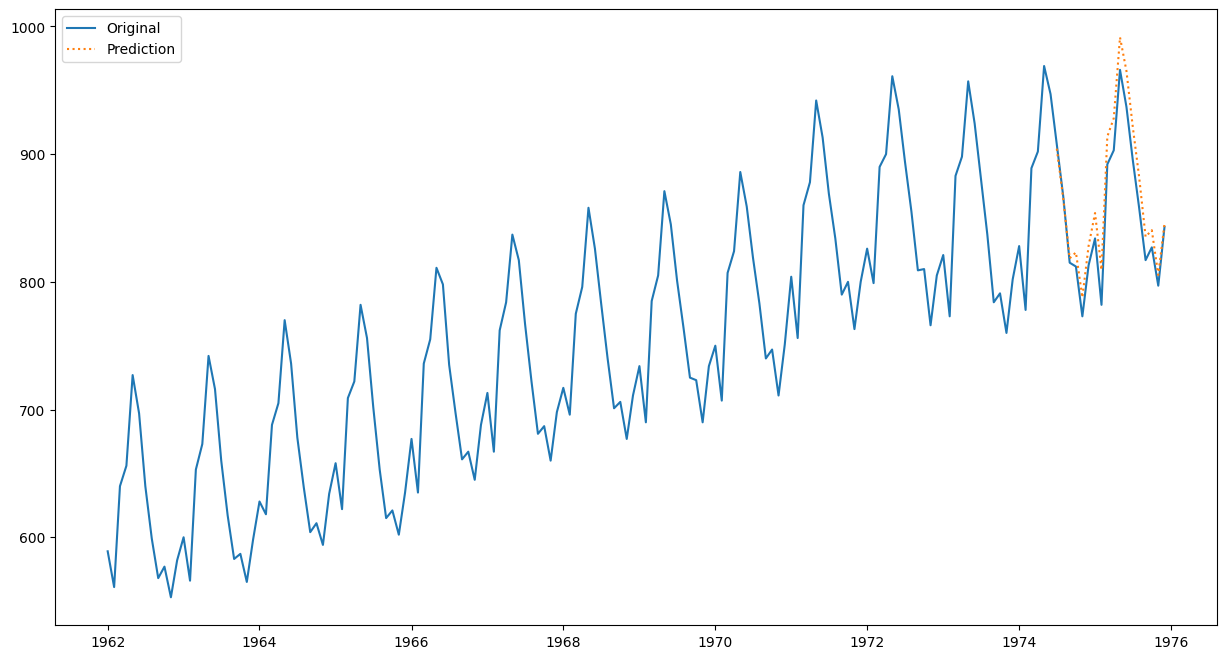

In [59]:
# Predict the existing values to compare the performance
model = SARIMAX(trained_df, order=(2,d,2), seasonal_order=(0,D,1,seasonal_period))
result = model.fit()

# Predict the last 18 values
predict_count = 18
predict_values = result.predict(start = 168-predict_count, end= 167, dynamic= True)  

# Plot the actual and the predicted values
fig = plt.figure(figsize=(15,8)) 
plt.plot(df['MilkProduction'])              
plt.plot(df.index[-predict_count:], predict_values, ':')
plt.legend(['Original','Prediction'],loc='upper left')
plt.show()

In [60]:
# Measure the prediction errors 
from sklearn.metrics import mean_absolute_error, mean_squared_error
actual_values = df['MilkProduction'][-predict_count:]
mae = mean_absolute_error(actual_values, predict_values)
mse = mean_squared_error(actual_values, predict_values)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 16.127379688421726
MSE: 340.8914197109655
RMSE: 18.463245102391006


In [61]:
# Predict the future values
model = SARIMAX(trained_df, order=(2,d,2), seasonal_order=(0,D,1,seasonal_period))
result = model.fit()

# Predict the next 12 values.  Each value is monthly-sampled
predict_count = 12  
predict_values = result.get_forecast(steps=predict_count)
predict_mean = predict_values.predicted_mean
predict_ci = predict_values.conf_int()
predict_mean

1976-01-01     867.172664
1976-02-01     820.142835
1976-03-01     926.518385
1976-04-01     939.460375
1976-05-01    1002.689162
1976-06-01     975.409770
1976-07-01     934.000998
1976-08-01     894.323259
1976-09-01     848.426959
1976-10-01     853.634247
1976-11-01     819.609855
1976-12-01     861.820464
Freq: MS, Name: predicted_mean, dtype: float64

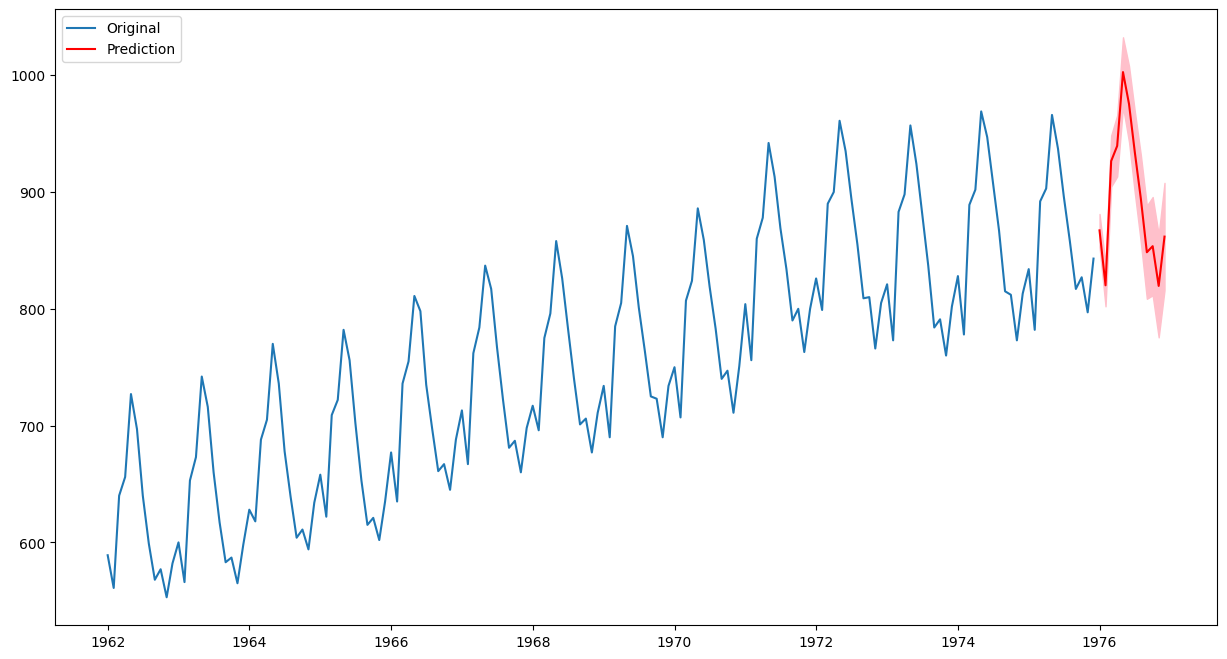

In [62]:
# Plot the actual, including the predicted future values
plt.figure(figsize=(15, 8))
plt.plot(df['MilkProduction'])
plt.plot(predict_mean, color='red')
plt.fill_between(predict_ci.index, predict_ci.iloc[:, 0], predict_ci.iloc[:, 1], color='pink')
plt.legend(['Original','Prediction'],loc='upper left')
plt.show()